In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pycaret.regression import RegressionExperiment

# 1. Import the dataset

In [3]:
project_dir = 'C:/Users/huang/Downloads/'
dataset = pd.read_csv(project_dir + 'train.csv')

# 2. Explore the dataset

In [4]:
dataset.head()

,CID,PID,Ef_Date,Ex_Date,Fw_Date,Cat1,Sub_Cat1,Cat2,Age_FW,Num1,...,Num2,Num3,Years_L,Num4,Num5,Num6,Num7,FP,SP,TP
0,0,1,2022-11-12,2023-11-12,2022-11-12,A,C,H,57.0,NaN,...,0.0625,0.083333,32.777550,0.0,0.0,0.0,0.0,0.204177,0.058454,0.058454
1,1,2,2017-09-17,2018-05-31,2016-09-17,A,C,J,39.0,NaN,...,0.0625,0.083333,22.297057,0.0,0.0,0.0,0.0,0.164734,0.040384,0.040384
2,2,3,2015-10-26,2015-10-26,2015-10-05,A,C,I,60.0,NaN,...,0.0625,0.083333,25.010267,0.0,0.0,0.0,0.0,0.306078,0.118623,0.118623
3,2,4,2015-10-26,2015-10-26,2015-10-01,A,C,I,60.0,NaN,...,0.2500,0.083333,24.999316,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,2,5,2015-10-26,2015-10-26,2015-10-02,B,I,I,60.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dataset.shape
print(f'There are {dataset.shape[0]:,} rows and {dataset.shape[1]} columns in the dataset.')

There are 287,526 rows and 22 columns in the dataset.


In [7]:
# Get the basic information of the dataset
number_of_missing_values = dataset.isnull().sum()   # Count the number of missing values
percentage_of_missing_values = ((number_of_missing_values / dataset.shape[0]) * 100).apply('{:.2f}'.format)   # Calculate the percentage of missing values
info = {
    'Data Type': dataset.dtypes,  # Get the data type of each column
    'Number of Unique Values': dataset.nunique(),   # Get the number of unique values in each column
    'Number of Missing Values': number_of_missing_values,
    'Percentage of Missing Values': percentage_of_missing_values
}
pd.DataFrame(info)

,Data Type,Number of Unique Values,Number of Missing Values,Percentage of Missing Values
CID,int64,179567,0,0.00
PID,int64,287526,0,0.00
Ef_Date,object,3075,0,0.00
Ex_Date,object,3429,0,0.00
Fw_Date,object,2940,1,0.00
Cat1,object,2,0,0.00
Sub_Cat1,object,19,0,0.00
Cat2,object,16,0,0.00
Age_FW,float64,93,21798,7.58
Num1,float64,66,258246,89.82


In [9]:
# Convert 'Ef_Date', 'Ex_Date', and 'Fw_Date' to datetime
dataset['Fw_Date'] = pd.to_datetime(dataset['Fw_Date'])
dataset['Ef_Date'] = pd.to_datetime(dataset['Ef_Date'])
dataset['Ex_Date'] = pd.to_datetime(dataset['Ex_Date'])

In [10]:
# Check the date related information
date_info = {'Earliest Date': [], 'Latest Date': []}

for column in ['Ef_Date', 'Ex_Date', 'Fw_Date']:
    date_info['Earliest Date'].append(dataset[column].min())
    date_info['Latest Date'].append(dataset[column].max())

pd.DataFrame(date_info, index=['Ef_Date', 'Ex_Date', 'Fw_Date'])


,Earliest Date,Latest Date
Ef_Date,2015-01-01,2023-07-29
Ex_Date,2001-09-10,2118-07-07
Fw_Date,2014-11-26,2051-10-15


In [11]:
print('As the latest date shows, there might be incorrect entries.')
print('And the earliest date of Expires is much earlier than Effective date, this is also incorrect.')

As the latest date shows, there might be incorrect entries.
And the earliest date of Expires is much earlier than Effective date, this is also incorrect.


# 3. Clean the dataset

In [13]:
# Check the rows where Ex_Date date earlier than Ef_Date date
dataset[dataset['Ex_Date'] < dataset['Ef_Date']]

,CID,PID,Ef_Date,Ex_Date,Fw_Date,Cat1,Sub_Cat1,Cat2,Age_FW,Num1,...,Num2,Num3,Years_L,Num4,Num5,Num6,Num7,FP,SP,TP
751,494,752,2022-02-14,2022-01-14,2021-12-14,A,C,J,64.0,NaN,...,0.0625,0.083333,29.620808,0.0,0.0,0.0,0.0,0.152062,0.027682,0.027682
930,605,931,2016-01-19,2015-12-08,2015-01-19,A,C,J,43.0,NaN,...,0.1250,0.333333,22.132786,0.0,0.0,0.5,0.0,0.156595,0.075814,0.075814
1455,931,1456,2016-10-07,2016-08-26,2015-10-07,A,C,K,57.0,0.010526,...,0.3125,0.166667,19.515400,0.0,0.0,0.0,0.0,0.142421,0.056842,0.056842
2223,1414,2224,2016-04-10,2016-01-29,2015-04-10,A,C,H,21.0,0.000000,...,0.0625,0.083333,1.774127,0.0,0.0,0.0,0.0,0.186622,0.043445,0.043445
5382,3425,5383,2020-07-11,2020-06-11,2018-07-11,A,C,I,56.0,NaN,...,0.1250,0.083333,5.026694,0.0,0.0,0.0,0.0,0.146177,0.025833,0.030062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279158,174397,279224,2016-06-17,2016-06-05,2015-06-17,A,C,I,77.0,0.210526,...,0.0625,0.083333,30.622861,0.0,0.0,0.0,0.0,0.127445,0.022048,0.022048
279861,174845,279927,2015-12-15,2015-11-28,2015-05-26,B,I,I,52.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125992,0.014432,0.014432
282561,176528,282627,2016-02-18,2015-12-01,2015-02-19,A,C,M,31.0,NaN,...,0.0625,0.083333,14.466804,0.0,0.0,0.0,0.0,0.114297,0.005634,0.005634
283020,176823,283086,2016-08-26,2016-08-24,2015-08-26,A,C,K,20.0,0.010526,...,0.0625,0.250000,4.235455,0.0,0.0,0.5,0.0,0.194335,0.076346,0.076346


In [14]:
print('There are 189 rows with incorrect date values, and it is impossible to correct them. \nHere, we simply delete them.')

There are 189 rows with incorrect date values, and it is impossible to correct them. 
Here, we simply delete them.


In [15]:
# Delete the rows where Expires earlier than Effective date
dataset = dataset[~(dataset['Ex_Date'] < dataset['Ef_Date'])]

In [16]:
# Also, delete the rows where Fw_Date later than the latest Ef_Date date
dataset = dataset[~(dataset['Fw_Date'] > dataset['Ef_Date'].max())]

In [17]:
# Delete the rows where the Ex_Date later than the max date of Ef_Date date plus one year
dataset = dataset[~(dataset['Ex_Date'] > dataset['Ef_Date'].max() + pd.DateOffset(years=1))]

In [18]:
print('In the Num1 column, 89.92% are missing, we delete this column.')
dataset.drop(columns=['Num1'], axis=1, inplace=True)

In the Num1 column, 89.92% are missing, we delete this column.


In [19]:
# Calculate customer's age based on the Fw_Date and Age_FW
from datetime import datetime
def get_birth_year(row):
    if pd.isnull(row['Age_FW']):
        return np.nan
    else:
        return row['Fw_Date'].year - row['Age_FW']
# Apply the function to create the new column
dataset['Birth_Year'] = dataset.apply(get_birth_year, axis=1)
# Get the current year
current_year = datetime.now().year
# Subtract the birth year from the current year to get age
dataset['Age'] = current_year - dataset['Birth_Year']
dataset.drop(columns=['Birth_Year', 'Age_FW'], inplace=True)
# Check if the age of a single customer with multiple policies are the same, if not, use the first record
dataset['Age'] = dataset.groupby('CID')['Age'].transform('first')

In [20]:
# Double check the date related information
date_info = {'Earliest Date': [], 'Latest Date': []}

for column in ['Ef_Date', 'Ex_Date', 'Fw_Date']:
    date_info['Earliest Date'].append(dataset[column].min())
    date_info['Latest Date'].append(dataset[column].max())

pd.DataFrame(date_info, index=['Ef_Date', 'Ex_Date', 'Fw_Date'])

,Earliest Date,Latest Date
Ef_Date,2015-01-01,2023-07-29
Ex_Date,2015-01-01,2024-07-29
Fw_Date,2014-11-26,2023-02-21


In [21]:
print('This looks fine after deleting the rows with incorrect date values.')

This looks fine after deleting the rows with incorrect date values.


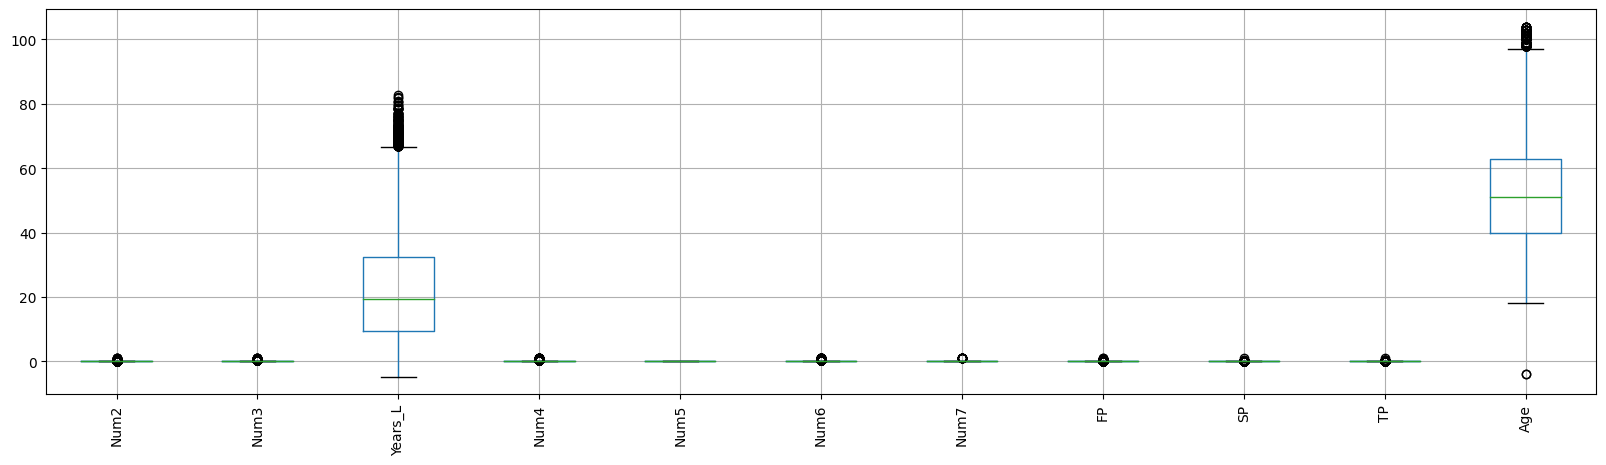

In [23]:
# Check the result of handling outliers

exclude_columns = ['CID', 'PID']
columns = [col for col in dataset.select_dtypes(include=['number']).columns if col not in exclude_columns]

dataset[columns].boxplot(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.show()

In [24]:
# Remove rows with outliers in the numeric columns with the consideration of null values

# Get the numeric column list
numeric_columns = dataset.select_dtypes(include=['number']).columns.to_list()

# Exclude the Premium columns
for column in ['FP', 'SP', 'TP']:
    numeric_columns.remove(column)

# Calculate the IQR
for column in numeric_columns:
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1

    # Create a boolean mask to identify outliers
    outliers_mask = (
        (dataset[column] >= (Q1 - 1.5 * IQR)) &
        (dataset[column] <= (Q3 + 1.5 * IQR))
    )

    # Include rows with NaN values
    outliers_mask = outliers_mask | dataset[column].isna()

    # Apply the mask to the DataFrame
    dataset = dataset[outliers_mask]

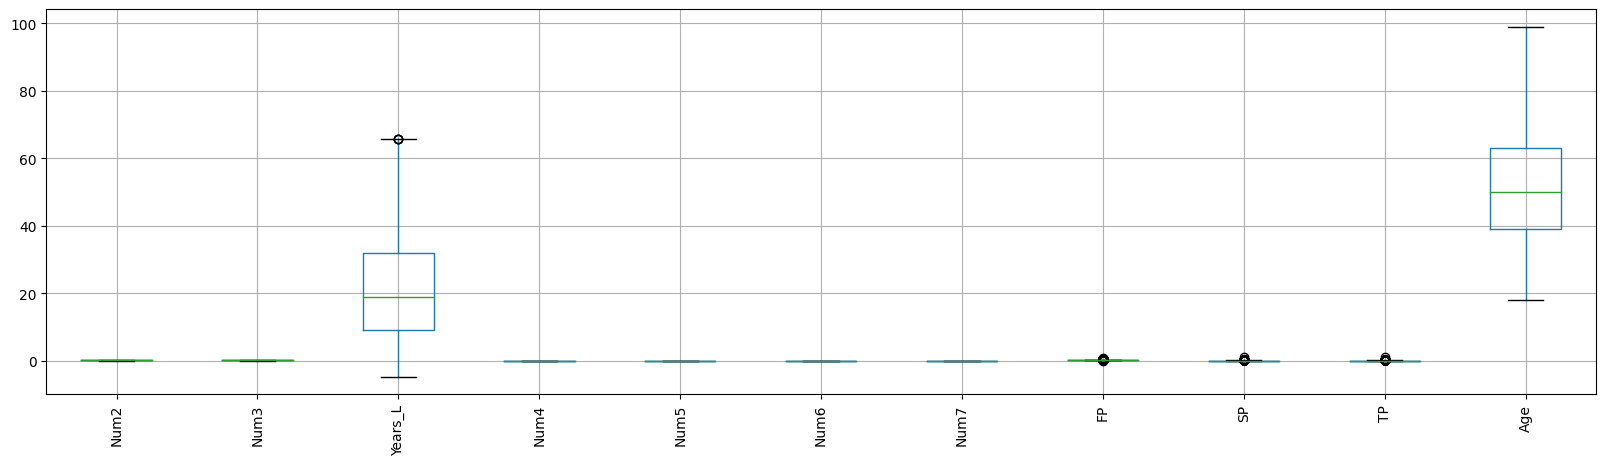

In [26]:
# Double Check the distribution of values
dataset[columns].boxplot(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.show()

In [27]:
print('Next, deal with the yearly premium.')

Next, deal with the yearly premium.


In [28]:
print('If the Expires date equals to the Effective date, this might mean the policy had never been activated, we need to modify the premiums to 0.')
print('If the Expires date does not equal to the Effective date, this might indicate a typo, and we can not find the true value of their premiums, we need to delete them.')

If the Expires date equals to the Effective date, this might mean the policy had never been activated, we need to modify the premiums to 0.
If the Expires date does not equal to the Effective date, this might indicate a typo, and we can not find the true value of their premiums, we need to delete them.


In [29]:
# If the Ex_Date date equals to the Ef_Date date and the premium is NaN, then modity the premium values to zero
condition = (dataset['Ex_Date'] == dataset['Ef_Date']) & dataset['FP'].isna()
columns_to_zero = ['FP', 'SP', 'TP']
dataset.loc[condition, columns_to_zero] = 0

In [30]:
# If the Ex_Date date does not equal to the Ef_Date date and the premium is NaN, then delete those rows
condition = (dataset['Ex_Date'] != dataset['Ef_Date']) & dataset['FP'].isna()
dataset.drop(dataset[condition].index, inplace=True)

In [31]:
# Calculate the duration days of each policy
dataset['Duration'] = (pd.to_datetime(dataset['Ex_Date'], format='%Y-%m-%d') - pd.to_datetime(dataset['Ef_Date'], format='%Y-%m-%d')).dt.days

In [32]:
# There are also some rows where FP is 0 but SP is not, we need to modify them
for index, row in dataset.iterrows():
    if row['FP'] == 0 and row['SP'] != 0:
        dataset.at[index, 'FP'] = dataset.at[index, 'SP']

In [33]:
import math
# Based on the duration, calculate the yearly premium of each policy
premium_list = []
for i in range(1, math.ceil(dataset['Duration'].max()/365) + 1):
    if i == 1:
        premium_index = '1st'
        base = 'FP'
    elif i == 2:
        premium_index = '2nd'
        base = 'SP'
    elif i == 3:
        premium_index = '3rd'
        base = 'TP'
    else:
        premium_index = f'{i}th'
        base = 'TP'
    dataset[premium_index] = 0
    premium_list.append(premium_index)
    for index, row in dataset.iterrows():
        if (row['Duration'] / 365 - i + 1) <= 0:
            dataset.at[index, premium_index] = 0
        elif 0 < (row['Duration'] / 365 - i + 1) < 1:
            dataset.at[index, premium_index] = round(row[base] / 365 * (row['Duration'] % 365), 0)
        elif (row['Duration'] / 365 - i + 1) >= 1:
            dataset.at[index, premium_index] = row[base]

C:\Users\huang\AppData\Local\Temp\ipykernel_3456\2906108652.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2041772056797976' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.at[index, premium_index] = row[base]
C:\Users\huang\AppData\Local\Temp\ipykernel_3456\2906108652.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0065803093484754' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.at[index, premium_index] = row[base]
C:\Users\huang\AppData\Local\Temp\ipykernel_3456\2906108652.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0066986070446278' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.at[index, premium_in

In [34]:
# Calculate the customer life-time value
dataset['LTV'] = 0
for premium in premium_list:
    dataset['LTV'] += dataset[premium]
 
# Delete all the used columns    
for column in ['Duration', 'FP', 'SP', 'TP']:
    premium_list.append(column)
dataset.drop(columns=premium_list, axis=1, inplace=True)

In [35]:
# Double check the information of each column
number_of_missing_values = dataset.isnull().sum()   # Count the number of missing values
percentage_of_missing_values = ((number_of_missing_values / dataset.shape[0]) * 100).apply('{:.2f}'.format)   # Calculate the percentage of missing values
info = {
    'Data Type': dataset.dtypes,  # Get the data type of each column
    'Number of Unique Values': dataset.nunique(),   # Get the number of unique values in each column
    'Number of Missing Values': number_of_missing_values,
    'Percentage of Missing Values': percentage_of_missing_values
}
pd.DataFrame(info)

,Data Type,Number of Unique Values,Number of Missing Values,Percentage of Missing Values
CID,int64,170831,0,0.00
PID,int64,267315,0,0.00
Ef_Date,datetime64[ns],3072,0,0.00
Ex_Date,datetime64[ns],3421,0,0.00
Fw_Date,datetime64[ns],2934,1,0.00
Cat1,object,2,0,0.00
Sub_Cat1,object,19,0,0.00
Cat2,object,16,0,0.00
Cat3,object,3,19800,7.41
Cat4,object,9,19801,7.41


In [36]:
dataset.head()

,CID,PID,Ef_Date,Ex_Date,Fw_Date,Cat1,Sub_Cat1,Cat2,Cat3,Cat4,Num2,Num3,Years_L,Num4,Num5,Num6,Num7,Age,LTV
0,0,1,2022-11-12,2023-11-12,2022-11-12,A,C,H,B,C,0.0625,0.083333,32.777550,0.0,0.0,0.0,0.0,59.0,0.204177
1,1,2,2017-09-17,2018-05-31,2016-09-17,A,C,J,B,C,0.0625,0.083333,22.297057,0.0,0.0,0.0,0.0,47.0,0.000000
2,2,3,2015-10-26,2015-10-26,2015-10-05,A,C,I,B,C,0.0625,0.083333,25.010267,0.0,0.0,0.0,0.0,69.0,0.000000
4,2,5,2015-10-26,2015-10-26,2015-10-02,B,I,I,B,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,0.000000
5,3,6,2016-07-05,2016-07-15,2016-04-05,A,C,H,A,C,0.0625,0.083333,2.097194,0.0,0.0,0.0,0.0,41.0,0.000000


In [37]:
print('Next, we will group policies by Cust_ID.')

Next, we will group policies by Cust_ID.


In [38]:
# Calculate CLTV and drop dulicates
dataset['CLTV'] = dataset.groupby('CID')['LTV'].transform('sum')
dataset.drop(columns=['LTV'], axis=1, inplace=True)

In [39]:
# Group by 'CID'
grouped = dataset.groupby('CID')

# Define a function to handle the columns
def custom_agg(group):
    result = group.copy()

    # Delete unnecessary columns
    result = result.drop(columns=['PID', 'Ef_Date', 'Ex_Date', 'Fw_Date', 'Cat1', 'Sub_Cat1'])

    # Handle missing values by keeping non-null values or larger values for numeric columns
    numeric_columns = result.select_dtypes(include=['number']).columns
    for column in numeric_columns:
        result[column] = result[column].ffill().bfill()  # Forward fill and then backward fill missing values
        result[column] = result[column].max()  # Keep the maximum value if there are duplicates

    return result

# Apply the custom aggregation function to each group
result_dataset = grouped.apply(custom_agg).drop_duplicates(subset='CID', keep='first').reset_index(drop=True)

In [40]:
result_dataset.head()

,CID,Cat2,Cat3,Cat4,Num2,Num3,Years_L,Num4,Num5,Num6,Num7,Age,CLTV
0,0,H,B,C,0.0625,0.083333,32.777550,0.0,0.0,0.0,0.0,59.0,0.204177
1,1,J,B,C,0.0625,0.083333,22.297057,0.0,0.0,0.0,0.0,47.0,0.000000
2,2,I,B,C,0.0625,0.083333,25.010267,0.0,0.0,0.0,0.0,69.0,0.000000
3,3,H,A,C,0.0625,0.083333,2.097194,0.0,0.0,0.0,0.0,41.0,0.000000
4,4,K,B,C,0.0625,0.083333,22.214921,0.0,0.0,0.0,0.0,65.0,0.124941


In [41]:
# Double check the information of each column
number_of_missing_values = result_dataset.isnull().sum()   # Count the number of missing values
percentage_of_missing_values = ((number_of_missing_values / result_dataset.shape[0]) * 100).apply('{:.2f}'.format)   # Calculate the percentage of missing values
info = {
    'Data Type': result_dataset.dtypes,  # Get the data type of each column
    'Number of Unique Values': result_dataset.nunique(),   # Get the number of unique values in each column
    'Number of Missing Values': number_of_missing_values,
    'Percentage of Missing Values': percentage_of_missing_values
}
pd.DataFrame(info)

,Data Type,Number of Unique Values,Number of Missing Values,Percentage of Missing Values
CID,int64,170831,0,0.00
Cat2,object,16,0,0.00
Cat3,object,3,17650,10.33
Cat4,object,9,17651,10.33
Num2,float64,4,34332,20.10
Num3,float64,4,34332,20.10
Years_L,float64,21582,37968,22.23
Num4,float64,1,28402,16.63
Num5,float64,1,28402,16.63
Num6,float64,1,28402,16.63


In [42]:
# Delete rows where CLTV less than 0
result_dataset = result_dataset[~(result_dataset['CLTV'] < 0)]

# Drop columns with no information
result_dataset.drop(columns=['CID', 'Num4', 'Num5', 'Num6', 'Num7'], axis=1, inplace=True)

In [44]:
result_dataset.head()

,Cat2,Cat3,Cat4,Num2,Num3,Years_L,Age,CLTV
0,H,B,C,0.0625,0.083333,32.777550,59.0,0.204177
1,J,B,C,0.0625,0.083333,22.297057,47.0,0.000000
2,I,B,C,0.0625,0.083333,25.010267,69.0,0.000000
3,H,A,C,0.0625,0.083333,2.097194,41.0,0.000000
4,K,B,C,0.0625,0.083333,22.214921,65.0,0.124941


# 4. Build the model

In [49]:
s = RegressionExperiment()
s.setup(result_dataset, target = 'CLTV', session_id = 123)
best = s.compare_models()

,Description,Value
0,Session id,123
1,Target,CLTV
2,Target type,Regression
3,Original data shape,"(170831, 8)"
4,Transformed data shape,"(170831, 33)"
5,Transformed train set shape,"(119581, 33)"
6,Transformed test set shape,"(51250, 33)"
7,Numeric features,4
8,Categorical features,3
9,Rows with missing values,24.8%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0915,0.0119,0.1090,0.1896,0.0952,0.3891,0.2380
xgboost,Extreme Gradient Boosting,0.0910,0.0119,0.1092,0.1868,0.0953,0.3952,0.2140
gbr,Gradient Boosting Regressor,0.0930,0.0121,0.1101,0.1724,0.0962,0.3843,1.1640
br,Bayesian Ridge,0.0958,0.0129,0.1137,0.1173,0.0993,0.3822,0.1590
ridge,Ridge Regression,0.0958,0.0129,0.1137,0.1173,0.0993,0.3822,0.0960
huber,Huber Regressor,0.0959,0.0134,0.1157,0.0868,0.1005,0.4253,0.7860
rf,Random Forest Regressor,0.0945,0.0135,0.1164,0.0762,0.1017,0.4317,3.4220
omp,Orthogonal Matching Pursuit,0.0988,0.0137,0.1169,0.0680,0.1020,0.3744,0.0990
ada,AdaBoost Regressor,0.0996,0.0138,0.1177,0.0554,0.1043,0.3129,0.7260
llar,Lasso Least Angle Regression,0.1020,0.0147,0.1211,-0.0001,0.1056,0.3497,0.0960


In [63]:

X = result_dataset[result_dataset.columns.drop(['CLTV'])]
y = result_dataset['CLTV']

X_encoded = pd.get_dummies(X, columns=['Cat2', 'Cat3', 'Cat4'])

# Trainset and testset spliting
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size= 0.2, random_state=42)

In [64]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Setup the LightGBM regressor
model = lgb.LGBMRegressor()

# Define the parameter grid for random search
param_dist = {
    'num_leaves': sp_randint(20, 50),
    'min_child_samples': sp_randint(100, 500),
    'min_child_weight': sp_uniform(0.01, 0.05),
    'subsample': sp_uniform(0.6, 0.4),
    'colsample_bytree': sp_uniform(0.6, 0.4),
    'reg_alpha': [0, 1, 1.5],
    'reg_lambda': [0, 1, 1.5],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Setup k-fold cross-validation
kf = KFold(n_splits=5)

# Setup Randomized Search
random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                   n_iter=100, scoring='neg_mean_squared_error', 
                                   cv=kf, verbose=1, n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 136664, number of used features: 24
[LightGBM] [Info] Start training from score 0.116827
Mean Squared Error: 0.01181418043498912


In [65]:
math.sqrt(mse)

0.10869305605690328

In [68]:
np.var(y_test)

0.014653729478016868